In [86]:
import numpy as np 
import pandas as pd
import seaborn as sns
import requests # For API requests
import json # For API requests
import time # To delay API & web scrapping pulls to avoid crashes
from bs4 import BeautifulSoup # For web scrapping
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from tqdm import tqdm
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
import os
import itertools
from datetime import datetime, timedelta
import datetime

os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.style.use('seaborn')
pd.options.display.max_rows = 1000
%matplotlib inline
pd.set_option('display.max_columns', 500)

# Webscrapping (worldometers)

In [36]:
# Gather urls from worldometers with BeautifulSoup
url_wld = 'https://www.worldometers.info/coronavirus/country/us'

In [37]:
import requests
page = requests.get(url_wld)
page

<Response [200]>

In [38]:
# utilized BeautifulSoup package to parse website
soup = BeautifulSoup(page.content, 'html.parser')

In [39]:
# clean up html for easier way of parsing
web_pret = soup.prettify()

In [40]:
# table needed is set under id below to pinpoint exact parts of the webpage that need to be scraped
results = soup.find(id='usa_table_countries_yesterday')

In [41]:
# using td format to get the scrape more exact
content = results.find_all('td')

In [42]:
# separated by state exactly which data points needed 
corona = []
for data in content:
    corona.append(data.text.strip())
corona[:20]

['',
 'USA Total',
 '5,655,974',
 '+43,999',
 '175,074',
 '+1,358',
 '3,011,098',
 '2,469,802',
 '17,087',
 '529',
 '72,367,651',
 '218,632',
 '',
 '',
 '1',
 'California',
 '640,420',
 '+5,350',
 '11,522',
 '+179']

In [43]:
# created a variable for each column where it would pull the value of every 11th item because there are 11 columns
state = corona[1::14]
state.pop()

total_cases = corona[2::14]
total_cases.pop()

new_cases = corona[3::14]
new_cases.pop()

total_deaths = corona[4::14]
total_deaths.pop()

new_deaths = corona[5::14]
new_deaths.pop()

active_cases = corona[7::14]
active_cases.pop()

total_cases_per_mil = corona[8::14]
total_cases_per_mil.pop()

total_deaths_per_mil = corona[9::14]
total_deaths_per_mil.pop()

total_tests = corona[10::14]
total_tests.pop()

total_tests_per_mil = corona[11::14]
total_tests_per_mil.pop()


'218,632'

In [44]:
# created a dictionary in order to make a dataframe
covid19 = {
    "state": state,
    "total_cases": total_cases,
    "new_cases": new_cases,
    "total_deaths": total_deaths,
    "new_deaths": new_deaths,
    "active_cases": active_cases,
    "total_cases_per_mil": total_cases_per_mil,
    "total_deaths_per_mil": total_deaths_per_mil,
    "total_tests": total_tests,
    "total_tests_per_mil": total_tests_per_mil}

In [45]:
dfc = pd.DataFrame.from_dict(covid19)
dfc.head()

,state,total_cases,new_cases,total_deaths,new_deaths,active_cases,total_cases_per_mil,total_deaths_per_mil,total_tests,total_tests_per_mil
0,USA Total,"5,655,974","+43,999","175,074","+1,358","2,469,802","17,087",529,"72,367,651","218,632"
1,California,"640,420","+5,350","11,522",+179,"364,874","16,208",292,"10,049,039","254,327"
2,Florida,"579,932","+3,838","9,764",+223,"513,314","27,002",455,"4,285,720","199,542"
3,Texas,"579,489","+7,872","10,298",+178,"153,288","19,985",355,"4,869,164","167,926"
4,New York,"456,836",+718,"32,932",+12,"66,790","23,483","1,693","7,191,978","369,700"


In [46]:
# Formated all of the columns to remove commas and or symbols
dfc['total_cases'] = dfc['total_cases'].map(lambda x: x.replace(',',''))
dfc['new_cases'] = dfc['new_cases'].map(lambda x: x.strip('+'))
dfc['new_cases'] = dfc['new_cases'].map(lambda x: x.replace(',',''))
dfc['total_deaths'] = dfc['total_deaths'].map(lambda x: x.replace(',',''))
dfc['new_deaths'] = dfc['new_deaths'].map(lambda x: x.strip('+'))
dfc['new_deaths'] = dfc['new_deaths'].map(lambda x: x.replace(',',''))
dfc['active_cases'] = dfc['active_cases'].map(lambda x: x.replace(',',''))
dfc['active_cases'] = dfc['active_cases'].map(lambda x: x.replace('N/A','0'))
dfc['total_cases_per_mil'] = dfc['total_cases_per_mil'].map(lambda x: x.replace(',',''))
dfc['total_deaths_per_mil'] = dfc['total_deaths_per_mil'].map(lambda x: x.replace(',',''))
dfc['total_tests'] = dfc['total_tests'].map(lambda x: x.replace(',',''))
dfc['total_tests_per_mil'] = dfc['total_tests_per_mil'].map(lambda x: x.replace(',',''))
# Replaced any empty cell values with 0
dfc.replace('',0, inplace = True)
#dfc['date'] = '08/08'
# Created a new column in which it would mark yesterday's time stamp
dfc['date'] = (datetime.datetime.now() - timedelta(days=1)).strftime('%m/%d')

In [47]:
dfc.head()

,state,total_cases,new_cases,total_deaths,new_deaths,active_cases,total_cases_per_mil,total_deaths_per_mil,total_tests,total_tests_per_mil,date
0,USA Total,5655974,43999,175074,1358,2469802,17087,529,72367651,218632,08/18
1,California,640420,5350,11522,179,364874,16208,292,10049039,254327,08/18
2,Florida,579932,3838,9764,223,513314,27002,455,4285720,199542,08/18
3,Texas,579489,7872,10298,178,153288,19985,355,4869164,167926,08/18
4,New York,456836,718,32932,12,66790,23483,1693,7191978,369700,08/18


In [48]:
# Convert all of the coumns into integer values
dfc['total_cases'] = dfc['total_cases'].astype(int)
dfc['new_cases'] = dfc['new_cases'].astype(int)
dfc['total_deaths'] = dfc['total_deaths'].astype(int)
dfc['new_deaths'] = dfc['new_deaths'].astype(int)
dfc['active_cases'] = dfc['active_cases'].astype(int)
dfc['total_cases_per_mil'] = dfc['total_cases_per_mil'].astype(int)
dfc['total_deaths_per_mil'] = dfc['total_deaths_per_mil'].astype(int)
dfc['total_tests'] = dfc['total_tests'].astype(int)
dfc['total_tests_per_mil'] = dfc['total_tests_per_mil'].astype(int)

In [49]:
dfc.dtypes

state                   object
total_cases              int64
new_cases                int64
total_deaths             int64
new_deaths               int64
active_cases             int64
total_cases_per_mil      int64
total_deaths_per_mil     int64
total_tests              int64
total_tests_per_mil      int64
date                    object
dtype: object

In [50]:
# import csv  #imported to have CSV file in a folder 
# dfc.to_csv('daily_corona.csv')

In [53]:
# instead of rewritting each csv, the mode 'a' allows to add onto each workbook
import csv  #imported to have CSV file in a folder 
dfc.to_csv('daily_corona.csv',mode='a',header=False)

In [55]:
dfcov = pd.read_csv('daily_corona.csv', index_col = 0)
dfcov.head()

,state,total_cases,new_cases,total_deaths,new_deaths,active_cases,total_cases_per_mil,total_deaths_per_mil,total_tests,total_tests_per_mil,date
0,USA Total,5151595,56071,165090,1000,2348035.0,15564.0,499.0,64610547.0,195196.0,08/08
1,California,556185,7031,10313,104,330839.0,14076.0,261.0,8707527.0,220376.0,08/08
2,Florida,526577,8502,8109,182,467525.0,24517.0,378.0,3952028.0,184006.0,08/08
3,Texas,504298,6892,8510,166,157445.0,17392.0,293.0,4329258.0,149306.0,08/08
4,New York,449828,837,32831,9,83542.0,23123.0,1688.0,6443832.0,331242.0,08/08


In [56]:
dfcov = dfcov[(dfcov['state']=='Arizona') | (dfcov['state']=='Nevada') | (dfcov['state']=='Ohio') | (dfcov['state']=='North Carolina') | (dfcov['state']=='Pennsylvania') | (dfcov['state']=='Wisconsin')]
dfcov = dfcov.reset_index(drop=True)
dfcov.head()


,state,total_cases,new_cases,total_deaths,new_deaths,active_cases,total_cases_per_mil,total_deaths_per_mil,total_tests,total_tests_per_mil,date
0,Arizona,186107,1054,4137,56,156807.0,25569.0,568.0,1253028.0,172150.0,08/08
1,North Carolina,135052,1699,2183,25,27776.0,12877.0,208.0,1969766.0,187810.0,08/08
2,Pennsylvania,122666,588,7394,11,24342.0,9582.0,578.0,1329720.0,103868.0,08/08
3,Ohio,99983,1289,3676,15,18878.0,8554.0,314.0,1639195.0,140233.0,08/08
4,Wisconsin,59933,1165,996,6,9654.0,10293.0,171.0,1046878.0,179801.0,08/08


In [59]:
df_az = dfcov[dfcov['state']=='Arizona']
df_az.head()

,state,total_cases,new_cases,total_deaths,new_deaths,active_cases,total_cases_per_mil,total_deaths_per_mil,total_tests,total_tests_per_mil,date
0,Arizona,186107,1054,4137,56,156807.0,25569.0,568.0,1253028.0,172150.0,08/08
6,Arizona,186923,816,4150,13,157246.0,25681.0,570.0,1260660.0,173198.0,08/09
12,Arizona,187523,600,4154,4,157521.0,25763.0,571.0,1267470.0,174134.0,08/10
18,Arizona,188737,1214,4199,45,158436.0,25930.0,577.0,1276952.0,175436.0,08/11
24,Arizona,189443,706,4347,148,159055.5,26071.5,589.5,1280869.0,175974.5,08/12


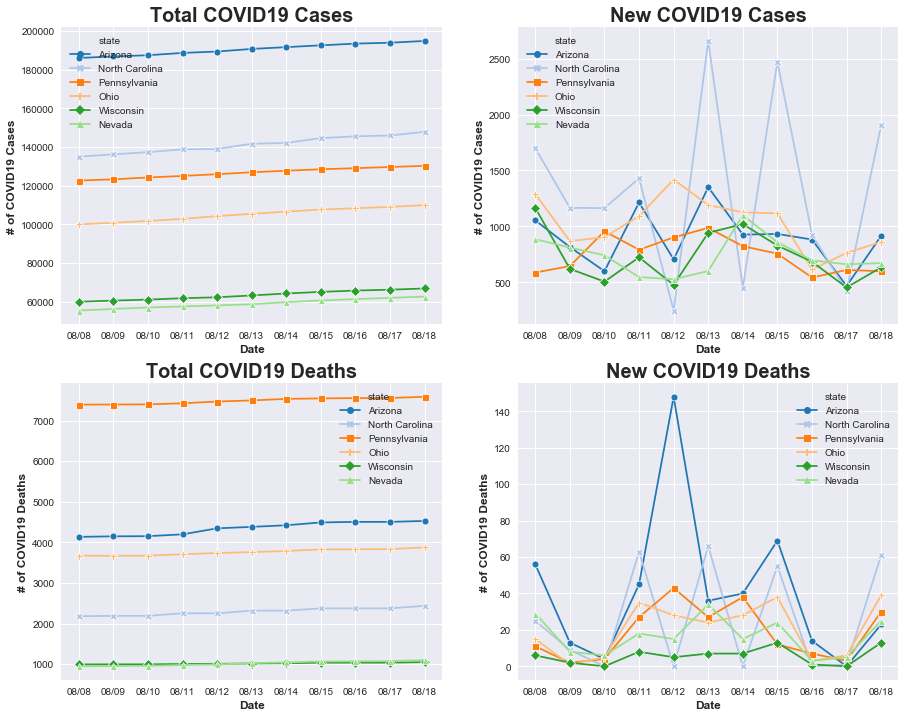

In [84]:
f,ax = plt.subplots(2,2, figsize=(15,12))
ax1,ax2,ax3,ax4 = ax.flatten()

sns.lineplot(x='date', y='total_cases', data=dfcov, hue ='state', style = 'state', palette = 'tab20', dashes = False, markers = True, ax =ax1)
ax1.set_xlabel('Date', fontsize = 12,fontweight='bold')
ax1.set_ylabel('# of COVID19 Cases', fontsize = 12,fontweight='bold')
ax1.set_title('Total COVID19 Cases',fontweight='bold', fontsize=(20))

sns.lineplot(x='date', y='new_cases', data=dfcov, hue ='state', style = 'state', palette = 'tab20', dashes = False, markers = True, ax =ax2)
ax2.set_xlabel('Date', fontsize = 12,fontweight='bold')
ax2.set_ylabel('# of COVID19 Cases', fontsize = 12,fontweight='bold')
ax2.set_title('New COVID19 Cases',fontweight='bold', fontsize=(20))

sns.lineplot(x='date', y='total_deaths', data=dfcov, hue ='state', style = 'state', palette = 'tab20', dashes = False, markers = True, ax =ax3)
ax3.set_xlabel('Date', fontsize = 12,fontweight='bold')
ax3.set_ylabel('# of COVID19 Deaths', fontsize = 12,fontweight='bold')
ax3.set_title('Total COVID19 Deaths',fontweight='bold', fontsize=(20))

sns.lineplot(x='date', y='new_deaths', data=dfcov, hue ='state', style = 'state', palette = 'tab20', dashes = False, markers = True, ax =ax4)
ax4.set_xlabel('Date', fontsize = 12,fontweight='bold')
ax4.set_ylabel('# of COVID19 Deaths', fontsize = 12,fontweight='bold')
ax4.set_title('New COVID19 Deaths',fontweight='bold', fontsize=(20));
# plt.savefig('Covid19_Data.png')

# Yelp Dataset

In [258]:
# imported business dataset from yep which consisted of over 200,000+ businesses
dfb = pd.read_json('yelp_academic_dataset_business.json', lines = True)
dfb.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


In [259]:
import csv  #imported to have CSV file in a folder 
dfb.to_csv('yelp_business.csv')

# Data Cleaning

In [87]:
dfb = pd.read_csv('yelp_business.csv', index_col = 0)
# removed many unneccessary columns
dfb.drop(columns='hours',inplace=True)
dfb.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,..."
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,NaN,"Pets, Pet Services, Pet Groomers"
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726649,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma..."


In [88]:
dfb.isnull().sum().sort_values(ascending = False)

attributes      29045
address          8679
categories        524
postal_code       509
city                2
name                1
is_open             0
review_count        0
stars               0
longitude           0
latitude            0
state               0
business_id         0
dtype: int64

In [89]:
# Any NaN values in these columns were dropped as I can not substitute it with any other values like mean or median
dfb.dropna(subset=(['attributes','address','categories','postal_code','city','name']), inplace=True)

In [90]:
# Wanted to see the distribution between states. Want to eliminate any states which had less than 1000 businesses in the dataset
dfb.state.value_counts(ascending = False)

AZ     49090
NV     31856
ON     30699
OH     13896
NC     13575
PA     10626
QC      9093
AB      6884
WI      4786
IL      1744
SC      1098
NY        19
CA        14
TX         5
WA         4
VT         2
CO         2
GA         2
BC         2
FL         2
AK         1
XWY        1
AR         1
AL         1
CT         1
MB         1
HI         1
NE         1
YT         1
VA         1
OR         1
UT         1
Name: state, dtype: int64

In [91]:
# subsetted the chosen states into a new data set
dfb = dfb[(dfb['state']=='AZ') | (dfb['state']=='NV') | (dfb['state']=='OH') | (dfb['state']=='NC') | (dfb['state']=='PA') | (dfb['state']=='WI') | (dfb['state']=='IL') | (dfb['state']=='SC')]
dfb.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,..."
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726649,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma..."
5,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Oil Change Stations, ..."


In [92]:
# Next only wanted to account for cities which had at least 100 businesses in the data set
counts = dfb.city.value_counts(ascending = False)
counts[counts>100]

Las Vegas             25775
Phoenix               15921
Charlotte              8721
Scottsdale             7701
Pittsburgh             6564
Mesa                   5324
Henderson              4308
Tempe                  4023
Chandler               3798
Cleveland              3218
Madison                3202
Glendale               3084
Gilbert                2973
Peoria                 1708
North Las Vegas        1362
Champaign              1153
Surprise                991
Concord                 846
Goodyear                758
Matthews                674
Avondale                625
Huntersville            583
Fort Mill               567
Lakewood                492
Mentor                  478
Gastonia                471
Akron                   450
Cornelius               427
Westlake                394
Monroeville             374
North Olmsted           369
Strongsville            369
Urbana                  360
Middleton               342
Cuyahoga Falls          340
Cave Creek          

In [93]:
# Subsetted a new dataframe with the minimum city parameters
dfb = dfb[dfb['city'].isin(counts[counts>100].index)]
dfb.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,..."
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726649,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma..."
5,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Oil Change Stations, ..."


In [94]:
# Any city tag related to Las Vegas was groupped together
dfb['city'] = np.where(dfb['city']=='North Las Vegas','Las Vegas',dfb['city'])

# Feature Engineering

In [95]:
# There are 1000's of sub categories that Yelp uses, so I researched what the main parent categories are in order to feature engineer new columns
parent_categories = ['Active Life','Arts & Entertainment','Automotive','Beauty & Spas','Education','Event Planning & Services',
                    'Financial Services','Food','Health & Medical','Home Services','Hotels & Travel','Local Flavor','Local Services',
                    'Mass Media','Nightlife','Pets','Professional Services','Public Services & Government','Real Estate',
                    'Religious Organizations','Restaurants','Shopping']

In [96]:
# explode function will create a duplicate row for each value in the category cell in order to quickly separate the multiple categories
dfb = dfb.assign(categories = dfb.categories.str.split(', ')).explode('categories')
dfb.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...",Active Life
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...",Gun/Rifle Ranges
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...",Guns & Ammo
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...",Shopping
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...",Health & Medical


In [97]:
# Using the parent category list I created earlier, I removed the child categories to feature engineer for the main category a business should be labeled as
dfb = dfb[dfb['categories'].isin(parent_categories)].drop_duplicates(subset='business_id',keep='first').reset_index(drop=True)

In [98]:
dfb.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...",Active Life
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...",Health & Medical
2,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...",Home Services
3,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726649,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...",Home Services
4,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,{'BusinessAcceptsCreditCards': 'True'},Automotive


In [99]:
# In order to parse through the attribute columns I used the eval() function to convert it all into dictionaries
dfb['postal_code'] = dfb['postal_code'].astype(int)
dfb['attributes'] = dfb['attributes'].map(lambda x: eval(x))

In [100]:
# json_normalize is an amazing function that will separate each key in all of the different dictionaries and organize
# them together into a data frame
dfb2 = pd.json_normalize(dfb['attributes'])
dfb2.head()

,BusinessAcceptsCreditCards,BikeParking,GoodForKids,BusinessParking,ByAppointmentOnly,RestaurantsPriceRange2,DogsAllowed,WiFi,RestaurantsAttire,RestaurantsTakeOut,NoiseLevel,RestaurantsReservations,RestaurantsGoodForGroups,HasTV,Alcohol,RestaurantsDelivery,OutdoorSeating,Caters,WheelchairAccessible,AcceptsInsurance,Ambience,BusinessAcceptsBitcoin,BYOB,GoodForMeal,Corkage,RestaurantsTableService,GoodForDancing,HappyHour,CoatCheck,BestNights,Music,Smoking,DriveThru,HairSpecializesIn,BYOBCorkage,AgesAllowed,RestaurantsCounterService,DietaryRestrictions,Open24Hours
0,True,True,False,"{'garage': False, 'street': False, 'validated'...",False,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,True,NaN,"{'garage': False, 'street': False, 'validated'...",False,4,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
# Dropped all of the columns not relevant
dfb2.drop(columns=['BikeParking','HasTV','Ambience','BusinessAcceptsBitcoin',
                  'GoodForMeal','NoiseLevel','RestaurantsAttire','Corkage','RestaurantsTableService',
                  'GoodForDancing','CoatCheck','BestNights','Music','HairSpecializesIn','BYOBCorkage',
                  'AgesAllowed','RestaurantsCounterService','DietaryRestrictions','Open24Hours','Smoking'],inplace = True)

In [109]:
# Cleaned up a lot of the columns in order essential create dummy variables for each of the attributes with values of 1 or 0
dfb2['BusinessAcceptsCreditCards'] = np.where(dfb2['BusinessAcceptsCreditCards']=='True',1,0)
dfb2['GoodForKids'] = np.where(dfb2['GoodForKids']=='True',1,0)
dfb2['BusinessParking'] = np.where(dfb2['BusinessParking']=='None',np.nan,dfb2['BusinessParking'])
dfb2['BusinessParking'] = dfb2['BusinessParking'].replace(np.nan,0)
dfb2['BusinessParking'] = np.where(dfb2['BusinessParking']==0,0,1)
dfb2['ByAppointmentOnly'] = np.where(dfb2['ByAppointmentOnly']=='True',1,0)
dfb2['RestaurantsPriceRange2'] = dfb2['RestaurantsPriceRange2'].replace(np.nan,0)
dfb2['RestaurantsPriceRange2'] = dfb2['RestaurantsPriceRange2'].replace('None',0)
dfb2['DogsAllowed'] = np.where(dfb2['DogsAllowed']=='True',1,0)
dfb2['WiFi'] = dfb2['WiFi'].replace({"u'free'":1,"'free'":1,"u'paid'":1,"'paid'":1})
dfb2['WiFi'] = np.where(dfb2['WiFi']==1,1,0)
dfb2['RestaurantsTakeOut'] = np.where(dfb2['RestaurantsTakeOut']=='True',1,0)
dfb2['RestaurantsReservations'] = np.where(dfb2['RestaurantsReservations']=='True',1,0)
dfb2['OutdoorSeating'] = np.where(dfb2['OutdoorSeating']=='True',1,0)
dfb2['RestaurantsDelivery'] = np.where(dfb2['RestaurantsDelivery']=='True',1,0)
dfb2['RestaurantsGoodForGroups'] = np.where(dfb2['RestaurantsGoodForGroups']=='True',1,0)
dfb2['Alcohol'] = dfb2['Alcohol'].replace({"u'full_bar'":1,"u'beer_and_wine'":1,"'full_bar'":1,"'beer_and_wine'":1})
dfb2['Alcohol'] = np.where(dfb2['Alcohol']==1,1,0)
dfb2['Caters'] = np.where(dfb2['Caters']=='True',1,0)
dfb2['WheelchairAccessible'] = np.where(dfb2['WheelchairAccessible']=='True',1,0)
dfb2['HappyHour'] = np.where(dfb2['HappyHour']=='True',1,0)
dfb2['AcceptsInsurance'] = np.where(dfb2['AcceptsInsurance']=='True',1,0)
dfb2['DriveThru'] = np.where(dfb2['DriveThru']=='True',1,0)
dfb2['BYOB'] = np.where(dfb2['BYOB']=='True',1,0)

In [111]:
dfb2.head()

,BusinessAcceptsCreditCards,GoodForKids,BusinessParking,ByAppointmentOnly,RestaurantsPriceRange2,DogsAllowed,WiFi,RestaurantsTakeOut,RestaurantsReservations,RestaurantsGoodForGroups,Alcohol,RestaurantsDelivery,OutdoorSeating,Caters,WheelchairAccessible,AcceptsInsurance,BYOB,HappyHour,DriveThru
0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [112]:
# Combined attribute features back to the main data frame
dfb = pd.concat([dfb, dfb2],axis=1)
dfb.drop(columns='attributes',inplace = True)
dfb.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,BusinessAcceptsCreditCards,GoodForKids,BusinessParking,ByAppointmentOnly,RestaurantsPriceRange2,DogsAllowed,WiFi,RestaurantsTakeOut,RestaurantsReservations,RestaurantsGoodForGroups,Alcohol,RestaurantsDelivery,OutdoorSeating,Caters,WheelchairAccessible,AcceptsInsurance,BYOB,HappyHour,DriveThru
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,Active Life,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,Health & Medical,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,Home Services,0,0,1,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726649,4.5,26,1,Home Services,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,Automotive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [113]:
# After all of the cleaning and some feature engineering left with 119,000 businesses and 30 features
dfb.shape

(119748, 31)

### Yelp Covid Dataset

In [114]:
# Due to the impact of Covid, Yelp created new features that are specifically related to covid related issues
dff = pd.read_json('yelp_academic_dataset_covid_features.json', lines = True)
dff.head()

,business_id,highlights,delivery or takeout,Grubhub enabled,Call To Action enabled,Request a Quote Enabled,Covid Banner,Temporary Closed Until,Virtual Services Offered
0,9kXRUIkwdDtnAPO6tVo51g,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
1,H6D5HOTfMjrZt7r1EObZ1g,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2,FYddq7fUtzobZcw4jOJgVA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,c75jLTjlgA9q3gImLEGT6w,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
4,YfzPiY50h_10Sjlg3mnNWQ,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [115]:
import csv  #imported to have CSV file in a folder 
dff.to_csv('yelp_covid_features.csv')

In [116]:
dff = pd.read_csv('yelp_covid_features.csv', index_col = 0)
# dropped not needed features for right now
dff.drop(columns=['highlights','Covid Banner'],inplace = True)
dff.head()

,business_id,delivery or takeout,Grubhub enabled,Call To Action enabled,Request a Quote Enabled,Temporary Closed Until,Virtual Services Offered
0,9kXRUIkwdDtnAPO6tVo51g,False,False,False,False,FALSE,FALSE
1,H6D5HOTfMjrZt7r1EObZ1g,False,False,False,False,FALSE,FALSE
2,FYddq7fUtzobZcw4jOJgVA,False,False,False,False,FALSE,FALSE
3,c75jLTjlgA9q3gImLEGT6w,False,False,False,False,FALSE,FALSE
4,YfzPiY50h_10Sjlg3mnNWQ,False,False,False,False,FALSE,FALSE


In [117]:
# Similar format of changing the different features into 1 or 0 values in order to incorporate into regression models
dff['delivery or takeout'] = np.where(dff['delivery or takeout']==True,1,0)
dff['Grubhub enabled'] = np.where(dff['Grubhub enabled']==True,1,0)
dff['Call To Action enabled'] = np.where(dff['Call To Action enabled']==True,1,0)
dff['Request a Quote Enabled'] = np.where(dff['Request a Quote Enabled']==True,1,0)
dff['Virtual Services Offered'] = np.where(dff['Virtual Services Offered']=='FALSE',0,1)

# Merging Yelp Datasets

In [118]:
# Combined the cleaned up business data set with the covid features
df_final = dfb.merge(dff, on ='business_id', how ='inner')
df_final = df_final.drop_duplicates(subset='business_id',keep='first')
df_final.drop(columns=['RestaurantsTakeOut','RestaurantsDelivery'],inplace = True)
df_final.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,BusinessAcceptsCreditCards,GoodForKids,BusinessParking,ByAppointmentOnly,RestaurantsPriceRange2,DogsAllowed,WiFi,RestaurantsReservations,RestaurantsGoodForGroups,Alcohol,OutdoorSeating,Caters,WheelchairAccessible,AcceptsInsurance,BYOB,HappyHour,DriveThru,delivery or takeout,Grubhub enabled,Call To Action enabled,Request a Quote Enabled,Temporary Closed Until,Virtual Services Offered
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,Active Life,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FALSE,0
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,Health & Medical,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FALSE,0
2,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,Home Services,0,0,1,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FALSE,0
3,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726649,4.5,26,1,Home Services,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,FALSE,0
4,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,Automotive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FALSE,0


In [119]:
import csv  #imported to have CSV file in a folder 
df_final.to_csv('yelp_business_edits.csv')

# More Feature Engineering: Dummy Variables

In [106]:
# There were two columns I wanted to create dummy variables for which was state and categories
# Creating this dummy variables would allow me incorporate them into the modeling process
pd.get_dummies(df_final['state'])

,AZ,IL,NC,NV,OH,PA,SC,WI
0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
120063,0,0,0,1,0,0,0,0
120064,0,0,0,0,1,0,0,0
120065,0,0,1,0,0,0,0,0
120066,0,0,1,0,0,0,0,0


In [107]:
pd.get_dummies(df_final['categories'])

,Active Life,Arts & Entertainment,Automotive,Beauty & Spas,Education,Event Planning & Services,Financial Services,Food,Health & Medical,Home Services,Hotels & Travel,Local Flavor,Local Services,Mass Media,Nightlife,Pets,Professional Services,Public Services & Government,Real Estate,Religious Organizations,Restaurants,Shopping
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120063,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
120064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
120065,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
120066,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [108]:
# added the new dummy variables into the main data frame
df = pd.get_dummies(df_final, columns=['state','categories'])
df.head()

,business_id,name,address,city,postal_code,latitude,longitude,stars,review_count,is_open,BusinessAcceptsCreditCards,GoodForKids,BusinessParking,ByAppointmentOnly,DogsAllowed,WiFi,RestaurantsReservations,RestaurantsGoodForGroups,Alcohol,OutdoorSeating,Caters,WheelchairAccessible,AcceptsInsurance,BYOB,HappyHour,DriveThru,delivery or takeout,Grubhub enabled,Call To Action enabled,Request a Quote Enabled,Temporary Closed Until,Virtual Services Offered,state_AZ,state_IL,state_NC,state_NV,state_OH,state_PA,state_SC,state_WI,categories_Active Life,categories_Arts & Entertainment,categories_Automotive,categories_Beauty & Spas,categories_Education,categories_Event Planning & Services,categories_Financial Services,categories_Food,categories_Health & Medical,categories_Home Services,categories_Hotels & Travel,categories_Local Flavor,categories_Local Services,categories_Mass Media,categories_Nightlife,categories_Pets,categories_Professional Services,categories_Public Services & Government,categories_Real Estate,categories_Religious Organizations,categories_Restaurants,categories_Shopping
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,28031,35.462724,-80.852612,3.5,36,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FALSE,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,85258,33.569404,-111.890264,5.0,4,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FALSE,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,Las Vegas,89030,36.219728,-115.127725,2.5,3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FALSE,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,85205,33.428065,-111.726649,4.5,26,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,FALSE,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,85233,33.350399,-111.827142,4.5,38,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FALSE,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [109]:
import csv  #imported to have CSV file in a folder 
df.to_csv('yelp_business_dummy_edits.csv')

# EDA

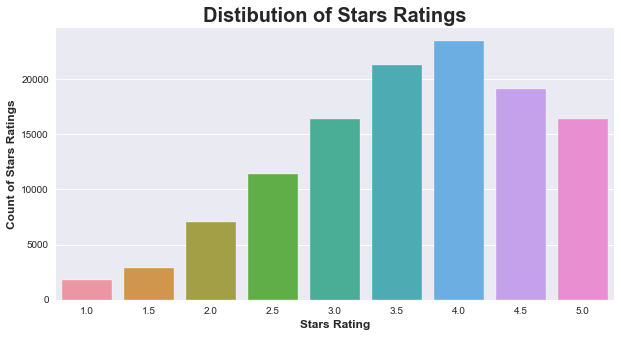

In [110]:
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df_final['stars'])
plt.title('Distibution of Stars Ratings', fontsize = 20,fontweight='bold')
plt.ylabel('Count of Stars Ratings', fontsize = 12,fontweight='bold')
plt.xlabel('Stars Rating', fontsize = 12,fontweight='bold');
# plt.savefig('Count_of_Ratings.png')

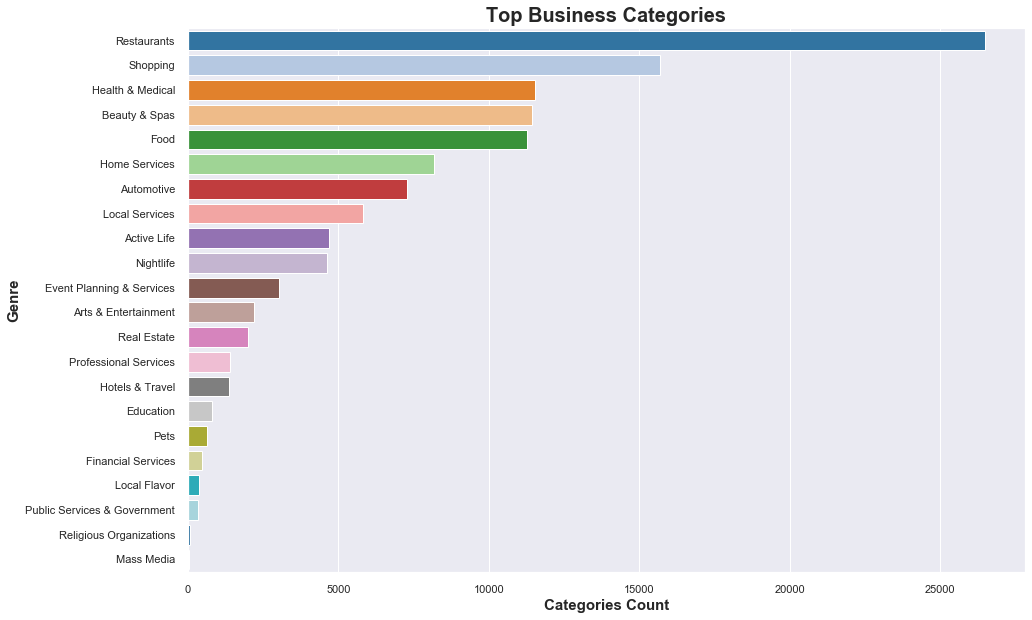

In [111]:
cat = df_final.categories.value_counts()
sns.set(style='darkgrid')
fig,ax=plt.subplots(figsize=(15,10))
ax =sns.barplot(cat, cat.index, palette = 'tab20')
ax.set_xlabel('Categories Count',fontweight='bold', fontsize=(15))
ax.set_ylabel('Genre',fontweight='bold', fontsize=(15))
ax.set_title('Top Business Categories', fontweight='bold', fontsize=(20));
# plt.savefig('Distribution_of_Categories.png')

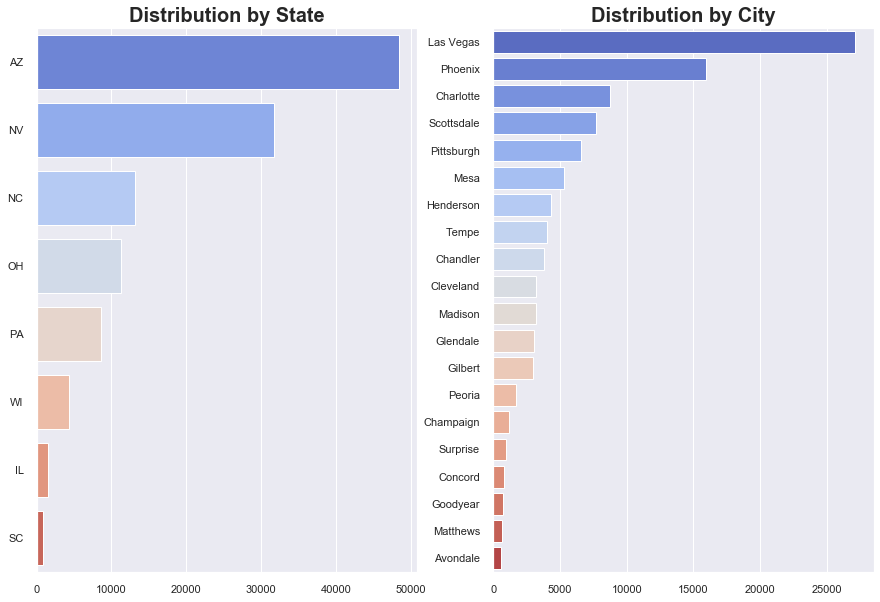

In [112]:
f,ax = plt.subplots(1,2, figsize=(15,10))
ax1,ax2, = ax.flatten()
state1 = df_final['state'].value_counts()

sns.barplot(state1, state1.index, palette = 'coolwarm', ax =ax1)
ax1.set_xlabel('')
ax1.set_title('Distribution by State',fontweight='bold', fontsize=(20))

city1 = df_final['city'].value_counts()[:20]

sns.barplot(city1, city1.index, palette = 'coolwarm', ax =ax2)
ax2.set_xlabel('')
ax2.set_title('Distribution by City',fontweight='bold', fontsize=(20));
# plt.savefig('Distibution_by_State_City.png')

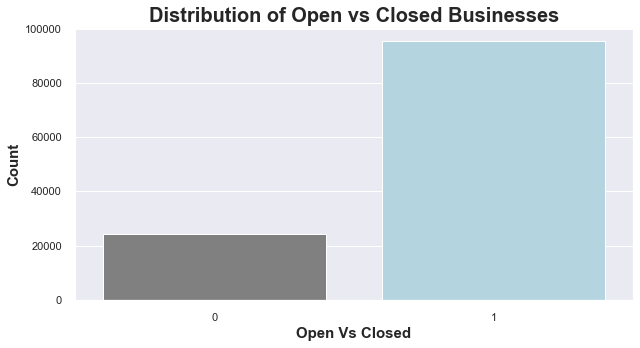

In [113]:
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df_final['is_open'], palette= ['grey','lightblue'])
plt.title('Distribution of Open vs Closed Businesses',fontweight='bold', fontsize=(20))
plt.ylabel('Count',fontweight='bold', fontsize=(15))
plt.xlabel('Open Vs Closed',fontweight='bold', fontsize=(15))
plt.show()
# plt.savefig('Distibution_by_Open_Closed.png')

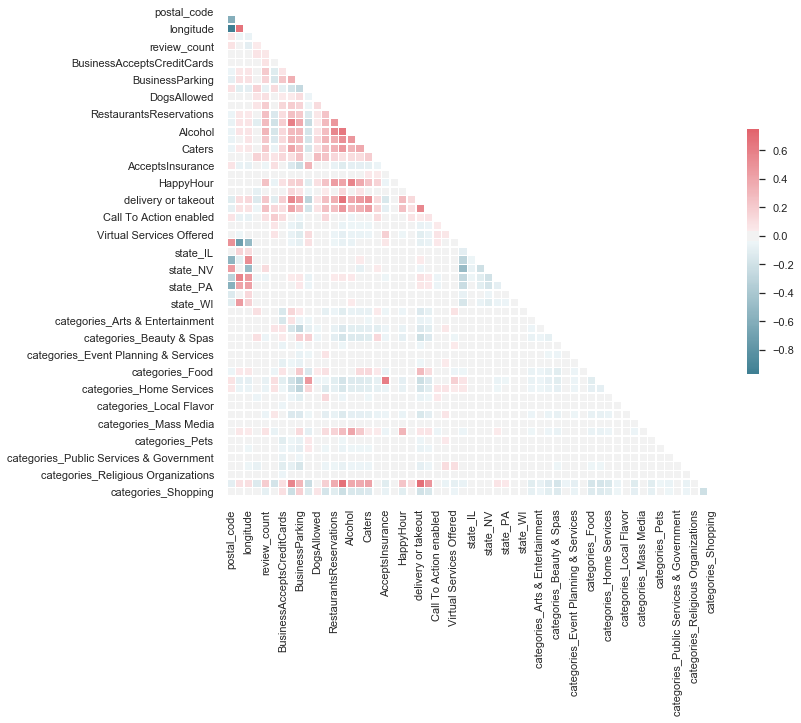

In [114]:
sns.set(style="white")
corr = df.corr() 

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# f.savefig('corr_heatmap.png',bbox_inches='tight');

# Hypothesis Testing

## #1 Two Sample T Test

Hypothesis Testing:

Null: No statistical difference between being open/closed and stars u1 = u2

Alternative: There is a statisitcal difference between being open/closed and stars u1 = u2 u1 =/ u2

In [115]:
# subset for each category of isopen I'm testing
isclosed = df_final[df_final['is_open']==0]
isopen = df_final[df_final['is_open']==1]

In [116]:
stats.ttest_ind(isclosed['stars'],isopen['stars'], equal_var = False)

Ttest_indResult(statistic=-26.146704608545345, pvalue=1.8754014252077548e-149)

We CAN reject the null hypothesis because our pvalue (1.54)e-149 is much less than 0.05 (alpha set at .05)

## #2 One way ANOVA

Hypothesis Testing:

Null: No statistical difference between mean of stars and state

Alternative: There is a statistical difference between mean of stars and state

In [117]:
stats.f_oneway(df_final['stars'][df_final['state'] == 'AZ'],
               df_final['stars'][df_final['state'] == 'NV'],
               df_final['stars'][df_final['state'] == 'NC'],
               df_final['stars'][df_final['state'] == 'OH'],
               df_final['stars'][df_final['state'] == 'PA'],
               df_final['stars'][df_final['state'] == 'WI'],
               df_final['stars'][df_final['state'] == 'IL'],
               df_final['stars'][df_final['state'] == 'SC'])

F_onewayResult(statistic=78.54057092435465, pvalue=2.914077410999466e-114)

We CAN reject the null hypothesis because our pvalue is less than 0.05 (alpha set at .05)

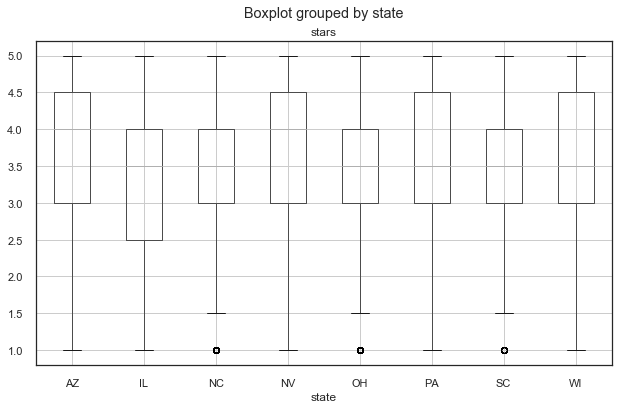

In [118]:
df_final.boxplot('stars', by='state', figsize=(10,6));
# plt.savefig('Boxplot_states_rating.png')

# Model & Feature Selection

## Model #1 Dummy Variables

In [119]:
features=['review_count', 'is_open','BusinessAcceptsCreditCards', 'GoodForKids', 'BusinessParking',
       'ByAppointmentOnly', 'DogsAllowed', 'WiFi', 'RestaurantsReservations',
       'RestaurantsGoodForGroups', 'Alcohol', 'OutdoorSeating', 'Caters',
       'WheelchairAccessible', 'AcceptsInsurance', 'BYOB', 'HappyHour',
       'DriveThru', 'delivery or takeout', 'Grubhub enabled',
       'Call To Action enabled', 'Request a Quote Enabled',
       'Virtual Services Offered', 'state_AZ',
       'state_IL', 'state_NC', 'state_NV', 'state_OH', 'state_PA', 'state_SC',
       'state_WI', 'categories_Active Life', 'categories_Arts & Entertainment',
       'categories_Automotive', 'categories_Beauty & Spas',
       'categories_Education', 'categories_Event Planning & Services',
       'categories_Financial Services', 'categories_Food',
       'categories_Health & Medical', 'categories_Home Services',
       'categories_Hotels & Travel', 'categories_Local Flavor',
       'categories_Local Services', 'categories_Mass Media',
       'categories_Nightlife', 'categories_Pets',
       'categories_Professional Services',
       'categories_Public Services & Government', 'categories_Real Estate',
       'categories_Religious Organizations', 'categories_Restaurants',
       'categories_Shopping']

df_features = df[features]

target = df['stars']

In [120]:
X_train,X_test, y_train, y_test = train_test_split(df_features, target, random_state=19,test_size=0.2)
lm = linear_model.LinearRegression()
lm = lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_pred = lm.predict(X_test)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training: '"{:.5f}".format(train_rmse), "vs. Testing: ""{:.5f}".format(test_rmse))

Training: 0.92196 vs. Testing: 0.91673


## Model #2 Polynomials

In [121]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df_features)
poly2_columns = poly_2.get_feature_names(df_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

,review_count,is_open,BusinessAcceptsCreditCards,GoodForKids,BusinessParking,ByAppointmentOnly,DogsAllowed,WiFi,RestaurantsReservations,RestaurantsGoodForGroups,Alcohol,OutdoorSeating,Caters,WheelchairAccessible,AcceptsInsurance,BYOB,HappyHour,DriveThru,delivery or takeout,Grubhub enabled,Call To Action enabled,Request a Quote Enabled,Virtual Services Offered,state_AZ,state_IL,state_NC,state_NV,state_OH,state_PA,state_SC,state_WI,categories_Active Life,categories_Arts & Entertainment,categories_Automotive,categories_Beauty & Spas,categories_Education,categories_Event Planning & Services,categories_Financial Services,categories_Food,categories_Health & Medical,categories_Home Services,categories_Hotels & Travel,categories_Local Flavor,categories_Local Services,categories_Mass Media,categories_Nightlife,categories_Pets,categories_Professional Services,categories_Public Services & Government,categories_Real Estate,categories_Religious Organizations,categories_Restaurants,categories_Shopping,review_count^2,review_count is_open,review_count BusinessAcceptsCreditCards,review_count GoodForKids,review_count BusinessParking,review_count ByAppointmentOnly,review_count DogsAllowed,review_count WiFi,review_count RestaurantsReservations,review_count RestaurantsGoodForGroups,review_count Alcohol,review_count OutdoorSeating,review_count Caters,review_count WheelchairAccessible,review_count AcceptsInsurance,review_count BYOB,review_count HappyHour,review_count DriveThru,review_count delivery or takeout,review_count Grubhub enabled,review_count Call To Action enabled,review_count Request a Quote Enabled,review_count Virtual Services Offered,review_count state_AZ,review_count state_IL,review_count state_NC,review_count state_NV,review_count state_OH,review_count state_PA,review_count state_SC,review_count state_WI,review_count categories_Active Life,review_count categories_Arts & Entertainment,review_count categories_Automotive,review_count categories_Beauty & Spas,review_count categories_Education,review_count categories_Event Planning & Services,review_count categories_Financial Services,review_count categories_Food,review_count categories_Health & Medical,review_count categories_Home Services,review_count categories_Hotels & Travel,review_count categories_Local Flavor,review_count categories_Local Services,review_count categories_Mass Media,review_count categories_Nightlife,review_count categories_Pets,review_count categories_Professional Services,review_count categories_Public Services & Government,review_count categories_Real Estate,review_count categories_Religious Organizations,review_count categories_Restaurants,review_count categories_Shopping,is_open^2,is_open BusinessAcceptsCreditCards,is_open GoodForKids,is_open BusinessParking,is_open ByAppointmentOnly,is_open DogsAllowed,is_open WiFi,is_open RestaurantsReservations,is_open RestaurantsGoodForGroups,is_open Alcohol,is_open OutdoorSeating,is_open Caters,is_open WheelchairAccessible,is_open AcceptsInsurance,is_open BYOB,is_open HappyHour,is_open DriveThru,is_open delivery or takeout,is_open Grubhub enabled,is_open Call To Action enabled,is_open Request a Quote Enabled,is_open Virtual Services Offered,is_open state_AZ,is_open state_IL,is_open state_NC,is_open state_NV,is_open state_OH,is_open state_PA,is_open state_SC,is_open state_WI,is_open categories_Active Life,is_open categories_Arts & Entertainment,is_open categories_Automotive,is_open categories_Beauty & Spas,is_open categories_Education,is_open categories_Event Planning & Services,is_open categories_Financial Services,is_open categories_Food,is_open categories_Health & Medical,is_open categories_Home Services,is_open categories_Hotels & Travel,is_open categories_Local Flavor,is_open categories_Local Services,is_open categories_Mass Media,is_open categories_Nightlife,is_open categories_Pets,is_open categories_Professional Services,is_open categories_Public Services & Government,is_open categories_Real Estate,is_open categories_R

In [122]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_poly2, target, random_state=19,test_size=0.2)
scaler2 = StandardScaler()
scaled = scaler2.fit(X_train2)

X_train2 = pd.DataFrame(data=scaler2.transform(X_train2), columns=df_poly2.columns)

X_test2 = pd.DataFrame(data=scaler2.transform(X_test2), columns=df_poly2.columns)

lm_2 = LinearRegression()

lm_2 = lm_2.fit(X_train2, y_train2)

y_train_pred2 = lm_2.predict(X_train2)

train2_rmse = np.sqrt(metrics.mean_squared_error(y_train2, y_train_pred2))

y_pred2 = lm_2.predict(X_test2)

test2_rmse = np.sqrt(metrics.mean_squared_error(y_test2, y_pred2))

print('Training: '"{:.5f}".format(train2_rmse), "vs. Testing: ""{:.5f}".format(test2_rmse))

Training: 0.88281 vs. Testing: 283276309893.04565


## Model #3 F Test


In [123]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

X_train3, X_test3, y_train3, y_test3 = train_test_split(df_features, target, random_state=19,test_size=0.2)

selector = SelectKBest(f_regression, k=25)

selector.fit(X_train3, y_train3)

SelectKBest(k=25, score_func=<function f_regression at 0x1a2109ec20>)

In [124]:
selected_columns = X_train3.columns[selector.get_support()]
removed_columns = X_train3.columns[~selector.get_support()]
# X_train = X_train3[selected_columns]
# X_test = X_test3[selected_columns]

In [125]:
list(removed_columns)

['BusinessAcceptsCreditCards',
 'BusinessParking',
 'RestaurantsReservations',
 'Alcohol',
 'OutdoorSeating',
 'Caters',
 'AcceptsInsurance',
 'BYOB',
 'HappyHour',
 'Call To Action enabled',
 'Request a Quote Enabled',
 'Virtual Services Offered',
 'state_PA',
 'state_SC',
 'state_WI',
 'categories_Arts & Entertainment',
 'categories_Automotive',
 'categories_Event Planning & Services',
 'categories_Financial Services',
 'categories_Food',
 'categories_Home Services',
 'categories_Local Flavor',
 'categories_Local Services',
 'categories_Mass Media',
 'categories_Nightlife',
 'categories_Public Services & Government',
 'categories_Religious Organizations',
 'categories_Shopping']

In [126]:
list(selected_columns)

['review_count',
 'is_open',
 'GoodForKids',
 'ByAppointmentOnly',
 'DogsAllowed',
 'WiFi',
 'RestaurantsGoodForGroups',
 'WheelchairAccessible',
 'DriveThru',
 'delivery or takeout',
 'Grubhub enabled',
 'state_AZ',
 'state_IL',
 'state_NC',
 'state_NV',
 'state_OH',
 'categories_Active Life',
 'categories_Beauty & Spas',
 'categories_Education',
 'categories_Health & Medical',
 'categories_Hotels & Travel',
 'categories_Pets',
 'categories_Professional Services',
 'categories_Real Estate',
 'categories_Restaurants']

In [127]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train3[selected_columns], y_train3)

y_train_kbest = lm_kbest.predict(X_train3[selected_columns])

train3_rmse = np.sqrt(metrics.mean_squared_error(y_train3, y_train_kbest))

y_kbest = lm_kbest.predict(X_test3[selected_columns])

test3_rmse = np.sqrt(metrics.mean_squared_error(y_test3, y_kbest))

print('Training: '"{:.5f}".format(train3_rmse), "vs. Testing: ""{:.5f}".format(test3_rmse))

Training: 0.92806 vs. Testing: 0.92216


## Model #4 Recursive Test

In [128]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(df_features, target, random_state=19,test_size=0.2)

from sklearn.feature_selection import RFECV

lm4 = linear_model.LinearRegression()

# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=lm4, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train4, y_train4)

selected_rfe = X_train4.columns[selector.support_]
removed_rfe = X_train4.columns[~selector.support_]

#instantiate a linear regression object
lm4_rfe = LinearRegression()

#fit the linear regression to the data
lm4_rfe = lm4_rfe.fit(X_train4[selected_rfe], y_train4)

y_rfe = lm4_rfe.predict(X_train4[selected_rfe])

train4_rmse = np.sqrt(metrics.mean_squared_error(y_train4, y_rfe))

y_pred_rfe = lm4_rfe.predict(X_test4[selected_rfe])

test4_rmse = np.sqrt(metrics.mean_squared_error(y_test4, y_pred_rfe))

print('Training: '"{:.5f}".format(train4_rmse), "vs. Testing: ""{:.5f}".format(test4_rmse))

Training: 0.92196 vs. Testing: 0.91673


## Model #5 Random Forest Regression

In [129]:
from sklearn.ensemble import RandomForestRegressor

X_train5,X_test5, y_train5, y_test5 = train_test_split(df_features, target, random_state=19,test_size=0.2)

sc = StandardScaler()
X_train5 = sc.fit_transform(X_train5)
X_test5 = sc.transform(X_test5)

/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  import sys


In [130]:
rg = RandomForestRegressor(n_estimators=300, random_state=19)
rg.fit(X_train5, y_train5)
y_train_pred5 = rg.predict(X_train5)
y_pred5 = rg.predict(X_test5)
train5_rmse = np.sqrt(metrics.mean_squared_error(y_train5, y_train_pred5))
test5_rmse = np.sqrt(metrics.mean_squared_error(y_test5, y_pred5))
print('Training: '"{:.5f}".format(train5_rmse), "vs. Testing: ""{:.5f}".format(test5_rmse))

Training: 0.64430 vs. Testing: 0.93852


## Randon Forest - Gridsearch

In [133]:
# established which parameters I can hypertune and gridsearch
param_grid = { 
    'n_estimators': [100,200,300],
    'max_features': [15,35,50],
    'max_depth' : [5,7,9]}

In [134]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(df_features, target, random_state=19,test_size=0.2)
rf_CV = RandomForestRegressor(random_state = 19)
rf_CV = GridSearchCV(estimator=rf_CV, param_grid=param_grid, cv= 5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
rf_CV.fit(X_train6, y_train6)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.0min


KeyboardInterrupt: 

In [955]:
# Identify the best params 
print(rf_CV.best_params_)
print(rf_CV.best_estimator_)


#Identify the best score during fitting with cross-validation
print(rf_CV.best_score_)

#predict on the test set
train_preds_rf_CV = rf_CV.best_estimator_.predict(X_train6)

test_preds_rf_CV = rf_CV.best_estimator_.predict(X_test6)

# checking rmse on train and test
train6_rmse = np.sqrt(metrics.mean_squared_error(y_train6, train_preds_rf_CV))

test6_rmse = np.sqrt(metrics.mean_squared_error(y_test6, test_preds_rf_CV))

print('Training: '"{:.5f}".format(train6_rmse), "vs. Testing: ""{:.5f}".format(test6_rmse))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# Model Results

In [1018]:
#  performed the best and will be used for my test
print('#1 Original Training Error: '"{:.5f}".format(train_rmse), '#1 Original Testing Error: '"{:.5f}".format(test_rmse))
print('#2 Poly Training Error: '"{:.5f}".format(train2_rmse), '#2 Poly Testing Error: '"{:.5f}".format(test2_rmse))
print('#3 F-Test Training Error: '"{:.5f}".format(train3_rmse), '#3 F-Test Testing Error: '"{:.5f}".format(test3_rmse))
print('#4 Recursive Training Error: '"{:.5f}".format(train4_rmse), '#4 Recursive Testing Error: '"{:.5f}".format(test4_rmse))
print('#5 Random Forest Training Error: '"{:.5f}".format(train5_rmse), '#5 Random Forest Testing Error: '"{:.5f}".format(test5_rmse))
print('#6 RF GridSearch Training Error: '"{:.5f}".format(train6_rmse), '#6 RF GridSearch Testing Error: '"{:.5f}".format(test6_rmse))


#1 Original Training Error: 0.92196 #1 Original Testing Error: 0.91673
#2 Poly Training Error: 0.88281 #2 Poly Testing Error: 283276309893.04565
#3 F-Test Training Error: 0.92806 #3 F-Test Testing Error: 0.92216
#4 Recursive Training Error: 0.92196 #4 Recursive Testing Error: 0.91673
#5 Random Forest Training Error: 0.64430 #5 Random Forest Testing Error: 0.93852


NameError: name 'train6_rmse' is not defined

# Prep for Recommendation Engine

In [26]:
%%time
dfr = pd.read_json('yelp_academic_dataset_review.json', lines = True)
dfr.head()

CPU times: user 3min 30s, sys: 19min, total: 22min 31s
Wall time: 1h 19min 13s


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [973]:
import csv  #imported to have CSV file in a folder 
dfr.to_csv('yelp_reviews.csv')

In [25]:
%%time
dfu = pd.read_json('yelp_academic_dataset_user.json', lines = True)
dfu.head()

CPU times: user 1min 30s, sys: 4min 25s, total: 5min 56s
Wall time: 16min 9s


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,225,227,,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",14,3.57,3,2,1,0,1,11,15,22,22,10,0
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,316,400,"2008,2009,2010,2011,2012,2013","ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",27,3.84,36,4,5,2,1,33,37,63,63,21,5
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,151,125,103,2010,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...",5,3.44,9,6,0,1,0,3,7,17,17,4,1
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,233,160,84,2009,"iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplfQ...",6,3.08,2,1,0,0,0,7,14,7,7,2,0
4,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,1265,400,512,"2009,2010,2011,2012,2014,2015,2016,2017,2018","3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyLQ...",78,4.37,8,9,2,1,1,22,28,31,31,19,31


In [974]:
import csv  #imported to have CSV file in a folder 
dfu.to_csv('yelp_users.csv')

In [85]:
%%time
dft = pd.read_json('yelp_academic_dataset_tip.json', lines = True)
dft.head()

CPU times: user 9 s, sys: 4.23 s, total: 13.2 s
Wall time: 17.2 s


,user_id,business_id,text,date,compliment_count
0,hf27xTME3EiCp6NL6VtWZQ,UYX5zL_Xj9WEc_Wp-FrqHw,Here for a quick mtg,2013-11-26 18:20:08,0
1,uEvusDwoSymbJJ0auR3muQ,Ch3HkwQYv1YKw_FO06vBWA,Cucumber strawberry refresher,2014-06-15 22:26:45,0
2,AY-laIws3S7YXNl_f_D6rQ,rDoT-MgxGRiYqCmi0bG10g,Very nice good service good food,2016-07-18 22:03:42,0
3,Ue_7yUlkEbX4AhnYdUfL7g,OHXnDV01gLokiX1ELaQufA,It's a small place. The staff is friendly.,2014-06-06 01:10:34,0
4,LltbT_fUMqZ-ZJP-vJ84IQ,GMrwDXRlAZU2zj5nH6l4vQ,"8 sandwiches, $24 total...what a bargain!!! An...",2011-04-08 18:12:01,0
